In [167]:
import pandas as pd
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

In [168]:
!pip install ace_tools

You should consider upgrading via the '/Users/christiangriset/elliptic-ai/ScrabbleAI/env/bin/python3 -m pip install --upgrade pip' command.


In [169]:
file_path = "../data/magpie-sims-400k.csv"

In [170]:
TILE_DIST = {
    "A": 9, "B": 2, "C": 2, "D": 4, "E": 12, "F": 2, "G": 3, "H": 2, "I": 9,
    "J": 1, "K": 1, "L": 4, "M": 2, "N": 6, "O": 8, "P": 2, "Q": 1, "R": 6,
    "S": 4, "T": 6, "U": 4, "V": 2, "W": 2, "X": 1, "Y": 2, "Z": 1, "?": 2
}

BASE_LEAVE = {k: 0 for k in TILE_DIST.keys()}

### Data Ingestion + Feature Engineering

In [171]:
# Open the file and iterate through each line
cnt = 0
training_data = []

start_time = time.time()

with open(file_path, 'r') as file:
    for line in file:
        cnt += 1
#         if cnt > 10:
#             break
        # Strip the line of leading/trailing whitespace
        line = line.strip()
        
        # Split the line by spaces (or any other delimiter as needed)
        parts = line.split()
        
        board_state = parts[0]
        leave = parts[1].replace("/", "")
        opp_score, player_score = map(int, parts[2].split("/"))
        score_diff = player_score - opp_score
        _, winProb, expDiff = map(float, parts[3].split(","))
        
        unseen_tiles = dict(TILE_DIST)
        leave_dict = dict(BASE_LEAVE)
        
        for el in board_state:
            if not el.isalpha():
                continue
            if el.islower():
                unseen_tiles["?"] -= 1
            else:
                unseen_tiles[el] -= 1
        
        for el in leave:
            unseen_tiles[el] -= 1
            leave_dict[el] += 1
        
        leave_flattened = [leave_dict[letter] for letter in TILE_DIST.keys()]
        unseen_tiles_flattened = [unseen_tiles[letter] for letter in TILE_DIST.keys()]
        
        # Total number of unseen tiles remaining
        total_unseen_tiles = sum(unseen_tiles.values())
        
        # Create a row for this data point with columns for each letter
        row = {
            "score_diff": score_diff,
            "total_unseen_tiles": total_unseen_tiles,
            **{f"leave_{letter}": leave_dict[letter] for letter in TILE_DIST.keys()},
            **{f"unseen_{letter}": unseen_tiles[letter] for letter in TILE_DIST.keys()},
            "winProb": winProb,
            "expPointDiff": expDiff
        }
        
        # Append the row to the training data list
        training_data.append(row)
        
# Record the end time
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.4f} seconds")

Total execution time: 6.7536 seconds


In [172]:
df = pd.DataFrame(training_data)
print(len(df))


395715


### Training

In [173]:
# Step 1: Prepare the features (X) and the target (y)

df_filtered = df[df.total_unseen_tiles >= 0]

print(len(df))
print(len(df_filtered))

X = df_filtered.drop(columns=['winProb', 'expPointDiff'])
y = df_filtered['winProb']  # Predicting win probability as a continuous value

# Step 2: Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


395715
395715


In [174]:
X_train.columns

Index(['score_diff', 'total_unseen_tiles', 'leave_A', 'leave_B', 'leave_C',
       'leave_D', 'leave_E', 'leave_F', 'leave_G', 'leave_H', 'leave_I',
       'leave_J', 'leave_K', 'leave_L', 'leave_M', 'leave_N', 'leave_O',
       'leave_P', 'leave_Q', 'leave_R', 'leave_S', 'leave_T', 'leave_U',
       'leave_V', 'leave_W', 'leave_X', 'leave_Y', 'leave_Z', 'leave_?',
       'unseen_A', 'unseen_B', 'unseen_C', 'unseen_D', 'unseen_E', 'unseen_F',
       'unseen_G', 'unseen_H', 'unseen_I', 'unseen_J', 'unseen_K', 'unseen_L',
       'unseen_M', 'unseen_N', 'unseen_O', 'unseen_P', 'unseen_Q', 'unseen_R',
       'unseen_S', 'unseen_T', 'unseen_U', 'unseen_V', 'unseen_W', 'unseen_X',
       'unseen_Y', 'unseen_Z', 'unseen_?'],
      dtype='object')

In [212]:
# Step 3: Set up the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_jobs=-1)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1], 
    'max_depth': [9],  
    'n_estimators': [1000]
}

# Step 5: Perform grid search with 3-fold cross-validation using the training set
# Time the grid search process
start_time = time.time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Record the end time after training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

# Print the best parameters and score from grid search
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score (negative MSE): {grid_search.best_score_}")

# Print training time
print(f"Training time: {training_time:.4f} seconds")

# Step 6: Use the best model from grid search and evaluate on the test set
best_model = grid_search.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = test_mse ** 0.5
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")

# Step 7: Visualize feature importance
plt.show()


Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000}
Best score (negative MSE): -0.005138130675706445
Training time: 50.3364 seconds
Test MSE: 0.0045
Test RMSE: 0.0673
Test R^2 Score: 0.9554


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

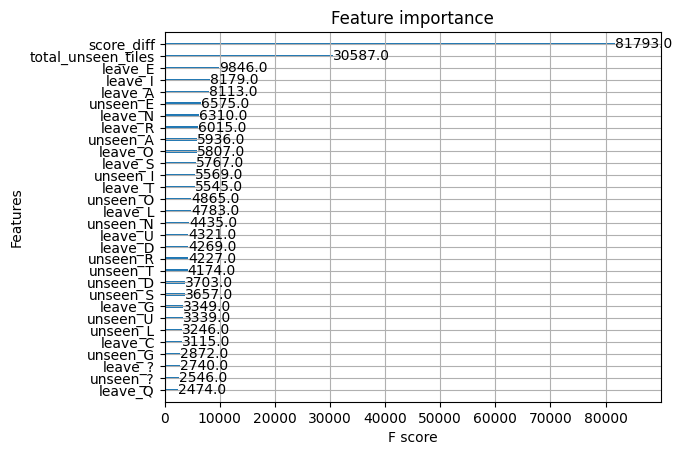

In [176]:
# Step 7: Visualize feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=30)

In [177]:
X_test_mod = X_test.copy()
X_test_mod["win_label"] = y_test
X_test_mod["win_pred"] = y_test_pred
X_test_mod["win_pred"] = X_test_mod["win_pred"].apply(lambda x: max(min(x, 1.0), 0))
X_test_mod["diff"] = (X_test_mod["win_pred"] - X_test_mod["win_label"]).apply(abs)

In [178]:
X_test_mod.head()

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_U,unseen_V,unseen_W,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff
316572,107,56,0,0,0,0,0,0,1,0,...,3,1,1,0,1,0,2,0.869173,0.865692,0.003481
316573,102,56,0,1,0,1,1,0,0,0,...,3,1,1,0,1,0,2,0.868395,0.879536,0.011141
316574,99,56,0,0,0,1,1,0,1,0,...,3,1,1,0,1,0,2,0.864066,0.879617,0.015551
316575,99,56,0,0,0,1,1,0,1,0,...,3,1,1,0,1,0,2,0.864021,0.879617,0.015596
316576,109,56,0,0,0,0,0,0,1,0,...,3,1,1,0,1,0,2,0.857882,0.867530,0.009648


In [179]:
X_test_mod["diff"].mean()

np.float64(0.02467948714013784)

In [180]:
# Sort by the 'diff' column to find rows with the largest differences
largest_diff_rows = X_test_mod.sort_values(by='diff', ascending=False)

# Display the top 10 rows with the largest differences
largest_diff_rows.head(10)

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_U,unseen_V,unseen_W,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff
340244,-7,3,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1.0,0.000000,1.000000
332013,15,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
387368,88,7,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,1.000000,1.000000
387365,96,7,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.998635,0.998635
380787,88,7,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.989088,0.989088
380788,92,7,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0.0,0.964348,0.964348
380791,88,7,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.964135,0.964135
360138,107,7,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,0.963998,0.963998
344083,-16,6,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1.0,0.036855,0.963145
384403,-18,7,0,0,0,0,2,0,0,0,...,0,0,1,0,0,0,0,1.0,0.037336,0.962664


In [181]:
import pandas as pd

# Define the bin edges for score_diff and tiles_remaining
score_diff_bins = [0, 20, 50, 100, 1000.0]
score_diff_labels = ['0-20', '20-50', '50-100', '100+']  # 4 bins, so 3 labels

tiles_remaining_bins = [0, 20, 50, 100]
tiles_remaining_labels = ['0-20', '20-50', '50-100']  # 4 bins, so 3 labels

# Create new columns with the buckets
X_test_mod['score_diff_bucket'] = pd.cut(abs(X_test_mod['score_diff']), bins=score_diff_bins, labels=score_diff_labels)
X_test_mod['tiles_remaining_bucket'] = pd.cut(X_test_mod['total_unseen_tiles'], bins=tiles_remaining_bins, labels=tiles_remaining_labels)

# Group by the buckets and compute the average and standard deviation of the 'diff'
grouped = X_test_mod.groupby(['score_diff_bucket', 'tiles_remaining_bucket'])['diff'].agg(['mean', 'std'])

# Convert mean and std to percentages and round to the nearest tenth
grouped['mean'] = (grouped['mean'] * 100).round(1)
grouped['std'] = (grouped['std'] * 100).round(1)
grouped.rename(columns={"mean": "err_mean", "std": "err_std"}, inplace=True)

# Display the results (you can also just use print(grouped) for a quick view in the console)
import IPython.display as display
display.display(grouped)

print(grouped)


/var/folders/fc/sjxxw3k551v4c5vjz3b4ph240000gn/T/ipykernel_95987/1341558218.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = X_test_mod.groupby(['score_diff_bucket', 'tiles_remaining_bucket'])['diff'].agg(['mean', 'std'])


err_mean  err_std
score_diff_bucket tiles_remaining_bucket                   
0-20              0-20                        13.7     18.0
                  20-50                        2.6      2.3
                  50-100                       1.2      1.1
20-50             0-20                         6.5     10.8
                  20-50                        2.3      2.0
                  50-100                       1.3      1.2
50-100            0-20                         3.6      8.9
                  20-50                        1.5      1.5
                  50-100                       1.0      1.0
100+              0-20                         1.1      3.5
                  20-50                        0.8      1.0
                  50-100                       0.8      0.7

                                          err_mean  err_std
score_diff_bucket tiles_remaining_bucket                   
0-20              0-20                        13.7     18.0
                  20-50                        2.6      2.3
                  50-100                       1.2      1.1
20-50             0-20                         6.5     10.8
                  20-50                        2.3      2.0
                  50-100                       1.3      1.2
50-100            0-20                         3.6      8.9
                  20-50                        1.5      1.5
                  50-100                       1.0      1.0
100+              0-20                         1.1      3.5
                  20-50                        0.8      1.0
                  50-100                       0.8      0.7


In [182]:
import pandas as pd

# Step 1: Define custom bins for total_unseen_tiles with ranges of 10
unseen_tiles_bins = pd.cut(X_test_mod['total_unseen_tiles'], bins=range(0, X_test_mod['total_unseen_tiles'].max() + 10, 10))

# Step 2: Assign the labels with the range of values for each bin
X_test_mod['unseen_tiles_bucket'] = unseen_tiles_bins.apply(lambda x: f'{int(x.left)} to {int(x.right)}')

# Step 3: Compute the average, count, and standard deviation of 'diff' for each unseen_tiles_bucket
bucket_stats = X_test_mod.groupby('unseen_tiles_bucket').agg(
    avg_diff=('diff', 'mean'),
    std_diff=('diff', 'std'),
    count=('diff', 'count'),
).reset_index()

# Step 4: Reexpress the avg_diff and std_diff as percentages
bucket_stats['avg_diff'] = bucket_stats['avg_diff'].apply(lambda x: round(x*100.0, 1))  # Convert to percentage
bucket_stats['std_diff'] = bucket_stats['std_diff'].apply(lambda x: round(x*100.0, 1))  # Convert to percentage

# Step 5: Display the updated stats, sorted by avg_diff
print(bucket_stats.sort_values(by='avg_diff', ascending=False))


  unseen_tiles_bucket  avg_diff  std_diff  count
0             0 to 10       6.4      13.9  13057
1            10 to 20       3.3       4.1   8254
2            20 to 30       2.1       2.2   7881
3            30 to 40       1.9       1.9   8246
4            40 to 50       1.7       1.5   7917
5            50 to 60       1.4       1.4   7243
6            60 to 70       1.3       1.2   7295
7            70 to 80       1.2       1.1   7272
8            80 to 90       1.1       0.9   7708
9           90 to 100       0.7       0.6   4270


/var/folders/fc/sjxxw3k551v4c5vjz3b4ph240000gn/T/ipykernel_95987/1666747520.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_stats = X_test_mod.groupby('unseen_tiles_bucket').agg(


In [183]:
X_test_mod_sans_end_game = X_test_mod[X_test_mod.total_unseen_tiles >= 20]

In [184]:
X_test_mod_sans_end_game

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff,score_diff_bucket,tiles_remaining_bucket,unseen_tiles_bucket
316572,107,56,0,0,0,0,0,0,1,0,...,0,1,0,2,0.869173,0.865692,0.003481,100+,50-100,50 to 60
316573,102,56,0,1,0,1,1,0,0,0,...,0,1,0,2,0.868395,0.879536,0.011141,100+,50-100,50 to 60
316574,99,56,0,0,0,1,1,0,1,0,...,0,1,0,2,0.864066,0.879617,0.015551,50-100,50-100,50 to 60
316575,99,56,0,0,0,1,1,0,1,0,...,0,1,0,2,0.864021,0.879617,0.015596,50-100,50-100,50 to 60
316576,109,56,0,0,0,0,0,0,1,0,...,0,1,0,2,0.857882,0.867530,0.009648,100+,50-100,50 to 60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395585,-83,24,0,0,0,0,0,0,0,0,...,0,0,0,1,0.016367,0.021387,0.005020,50-100,20-50,20 to 30
395586,-96,24,0,0,0,0,1,0,0,0,...,0,0,0,1,0.016029,0.016985,0.000956,50-100,20-50,20 to 30
395587,-102,24,1,0,0,0,1,0,0,0,...,0,0,0,1,0.015955,0.022197,0.006242,100+,20-50,20 to 30
395713,12,93,0,0,0,1,1,0,0,0,...,1,2,1,2,0.521567,0.505662,0.015905,0-20,50-100,90 to 100


In [185]:
test_mse = mean_squared_error(X_test_mod_sans_end_game["win_label"], X_test_mod_sans_end_game["win_pred"])
test_rmse = test_mse ** 0.5
test_r2 = r2_score(X_test_mod_sans_end_game["win_label"], X_test_mod_sans_end_game["win_pred"])

print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")

Test MSE: 0.0005
Test RMSE: 0.0214
Test R^2 Score: 0.9933


In [186]:
# Sort by the 'diff' column to find rows with the largest differences
largest_diff_rows = X_test_mod_sans_end_game.sort_values(by='diff', ascending=False)

# Display the top 10 rows with the largest differences
largest_diff_rows.head(10)

,score_diff,total_unseen_tiles,leave_A,leave_B,leave_C,leave_D,leave_E,leave_F,leave_G,leave_H,...,unseen_X,unseen_Y,unseen_Z,unseen_?,win_label,win_pred,diff,score_diff_bucket,tiles_remaining_bucket,unseen_tiles_bucket
391424,-8,25,0,0,0,0,1,0,0,0,...,1,1,0,1,0.159225,0.349612,0.190387,0-20,20-50,20 to 30
345656,-2,38,0,0,0,0,1,0,0,0,...,0,0,1,1,0.293427,0.473901,0.180474,0-20,20-50,30 to 40
362797,30,56,0,0,0,0,1,0,0,0,...,0,2,0,0,0.545574,0.724482,0.178908,20-50,50-100,50 to 60
341266,-12,31,0,0,1,0,2,0,0,0,...,0,0,1,1,0.535317,0.357201,0.178116,0-20,20-50,30 to 40
391449,19,20,0,0,1,0,0,0,0,0,...,1,1,0,0,0.486100,0.664177,0.178077,0-20,0-20,10 to 20
341265,-11,31,0,0,1,0,1,0,0,0,...,0,0,1,1,0.551291,0.373670,0.177621,0-20,20-50,30 to 40
341270,-22,31,0,0,1,0,1,0,0,0,...,0,0,1,1,0.460726,0.290652,0.170074,20-50,20-50,30 to 40
387223,25,24,1,1,0,0,0,0,0,0,...,0,0,1,0,0.460294,0.629679,0.169385,20-50,20-50,20 to 30
345657,-5,38,0,0,0,0,1,0,0,0,...,0,0,1,1,0.270748,0.436377,0.165629,0-20,20-50,30 to 40
360438,-20,44,1,0,0,0,0,0,0,0,...,0,1,1,1,0.222642,0.385733,0.163091,0-20,20-50,40 to 50


## Feature Ablation

In [187]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import time
import matplotlib.pyplot as plt

# Define a list of feature groups for ablation
feature_groups = {
    'score_diff': ['score_diff'],
    'tiles_remaining': ['total_unseen_tiles'],
    'leave': [col for col in X.columns if col.startswith('leave_')],
    'unseen': [col for col in X.columns if col.startswith('unseen_')],
}

# Step 4: Function to perform ablation and cross-validation
def ablation_experiment(X_train, y_train, param_grid):
    results = {}

    for feature_group_name, features_to_remove in feature_groups.items():
        # Remove the selected features
        X_train_ablation = X_train.drop(columns=features_to_remove)
        
        # Set up the model
        model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_jobs=-1)
        
        # Perform grid search with 3-fold cross-validation
        start_time = time.time()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train_ablation, y_train)
        end_time = time.time()
        
        # Record the training time
        training_time = end_time - start_time
        
        # Best model and parameters
        best_model = grid_search.best_estimator_
        
        # Store the results
        results[feature_group_name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'training_time': training_time,
            'best_model': best_model
        }
        
    return results

# Step 5: Perform ablation and cross-validation
param_grid = {
    'learning_rate': [0.02, 0.1], 
    'max_depth': [6, 9],  
    'n_estimators': [300, 1000]
}

ablation_results = ablation_experiment(X_train, y_train, param_grid)


In [188]:
ablation_results

{'score_diff': {'best_params': {'learning_rate': 0.02,
   'max_depth': 6,
   'n_estimators': 300},
  'best_score': np.float64(-0.10118930140793714),
  'training_time': 110.22266626358032,
  'best_model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='rmse', feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.02, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=-1,
               num_parallel_tree=None, random_state=None, ...)},
 'tiles_remaining': {'best_para

Results for score_diff ablation:
  Best Params: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 300}
  Best Score (Negative MSE): -0.10118930140793714
  Training Time: 110.2227 seconds
  Test MSE: 0.0985
  Test RMSE: 0.3139
  Test R^2 Score: 0.0309
--------------------------------------------------
Results for tiles_remaining ablation:
  Best Params: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 1000}
  Best Score (Negative MSE): -0.00569151794084469
  Training Time: 139.1462 seconds
  Test MSE: 0.0053
  Test RMSE: 0.0727
  Test R^2 Score: 0.9481
--------------------------------------------------
Results for leave ablation:
  Best Params: {'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 300}
  Best Score (Negative MSE): -0.007490950530076271
  Training Time: 84.2133 seconds
  Test MSE: 0.0069
  Test RMSE: 0.0831
  Test R^2 Score: 0.9320
--------------------------------------------------
Results for unseen ablation:
  Best Params: {'learning_rate': 0.02, 'max_de

<Figure size 1000x800 with 0 Axes>

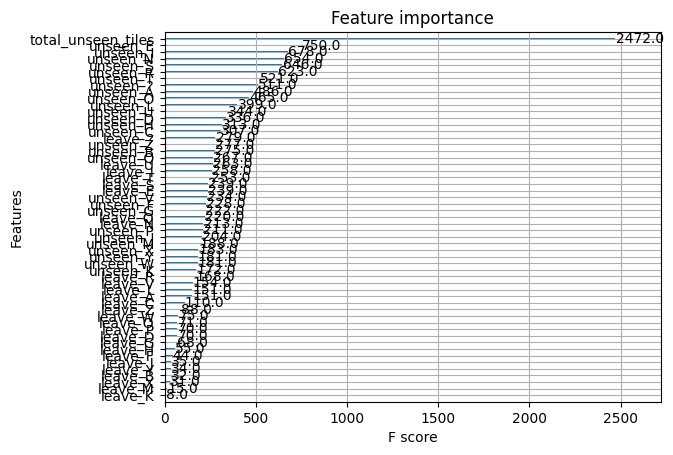

In [189]:
# Step 6: Evaluate on the test set for each ablation scenario
for feature_group_name, result in ablation_results.items():
    best_model = result['best_model']
    
    # Remove the same features from the test set that were removed from the training set
    features_to_remove = feature_groups[feature_group_name]
    X_test_ablation = X_test.drop(columns=features_to_remove)
    
    # Predict on the ablated test set
    y_test_pred = best_model.predict(X_test_ablation)
    
    # Evaluate performance on the test set
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = test_mse ** 0.5
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Output the results
    print(f"Results for {feature_group_name} ablation:")
    print(f"  Best Params: {result['best_params']}")
    print(f"  Best Score (Negative MSE): {result['best_score']}")
    print(f"  Training Time: {result['training_time']:.4f} seconds")
    print(f"  Test MSE: {test_mse:.4f}")
    print(f"  Test RMSE: {test_rmse:.4f}")
    print(f"  Test R^2 Score: {test_r2:.4f}")
    print("-" * 50)

# Optionally: Plot feature importance for the final model from the full feature set
final_model = ablation_results['score_diff']['best_model']
plt.figure(figsize=(10, 8))
xgb.plot_importance(final_model, importance_type='weight')
plt.show()


## Epochs

/Users/christiangriset/elliptic-ai/ScrabbleAI/env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


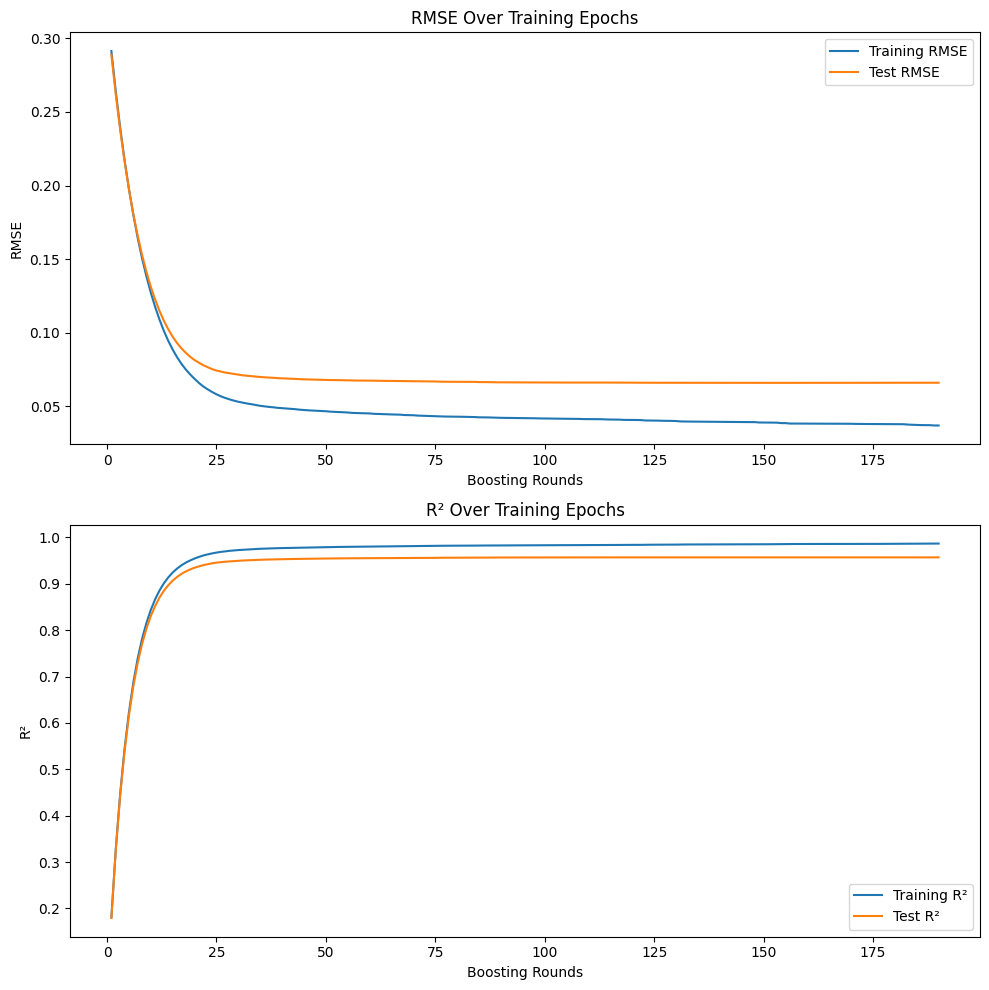

In [193]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Set up the model with parameters
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'learning_rate': 0.1, 
    'max_depth': 9, 
    'n_estimators': 3000,
    'n_jobs': -1
}

# Step 2: Convert data to DMatrix format (necessary for XGBoost training)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 3: Create evaluation sets
evals = [(dtrain, 'train'), (dtest, 'eval')]  # Define training and evaluation sets

# Step 4: Initialize the evals_result dictionary
evals_result = {}

# Step 5: Train the model with early stopping
history = xgb.train(params, dtrain, 
                    num_boost_round=3000, 
                    evals=evals, 
                    early_stopping_rounds=50,  # Stop after 50 rounds of no improvement
                    evals_result=evals_result,  # Pass in the evals_result to collect results
                    verbose_eval=False)

# Step 6: Access the evaluation results for training and test RMSE
train_rmse = evals_result['train']['rmse']  # Training RMSE
test_rmse = evals_result['eval']['rmse']  # Test RMSE

# Compute R² scores for each epoch on training and test set
train_r2 = [r2_score(y_train, history.predict(dtrain, iteration_range=(0, i))) for i in range(1, len(train_rmse)+1)]
test_r2 = [r2_score(y_test, history.predict(dtest, iteration_range=(0, i))) for i in range(1, len(test_rmse)+1)]

# Step 7: Plot RMSE and R² for both training and test sets over epochs
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot RMSE
axs[0].plot(range(1, len(train_rmse) + 1), train_rmse, label='Training RMSE')
axs[0].plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSE')
axs[0].set_title('RMSE Over Training Epochs')
axs[0].set_xlabel('Boosting Rounds')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# Plot R²
axs[1].plot(range(1, len(train_r2) + 1), train_r2, label='Training R²')
axs[1].plot(range(1, len(test_r2) + 1), test_r2, label='Test R²')
axs[1].set_title('R² Over Training Epochs')
axs[1].set_xlabel('Boosting Rounds')
axs[1].set_ylabel('R²')
axs[1].legend()

plt.tight_layout()
plt.show()


/Users/christiangriset/elliptic-ai/ScrabbleAI/env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


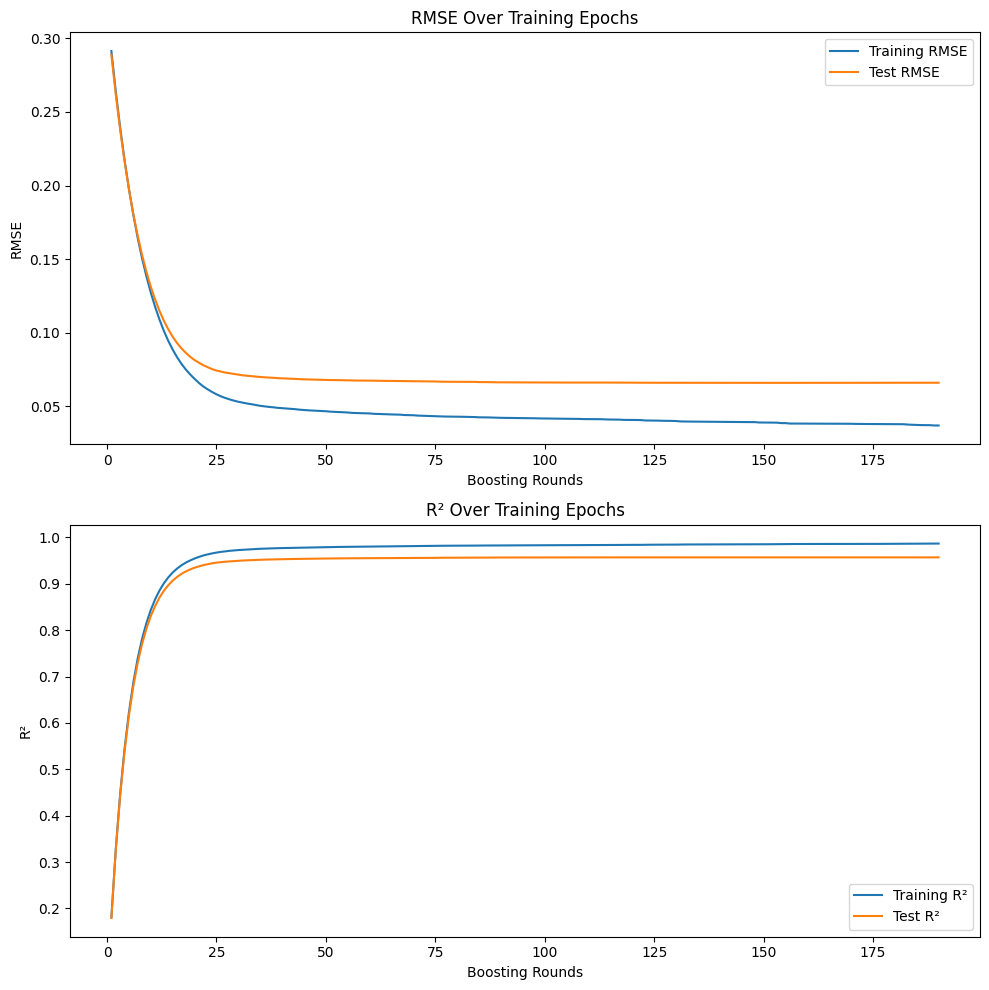

In [194]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Set up the model with parameters
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'learning_rate': 0.1, 
    'max_depth': 9, 
    'n_estimators': 3000,
    'n_jobs': -1
}

# Step 2: Convert data to DMatrix format (necessary for XGBoost training)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 3: Create evaluation sets
evals = [(dtrain, 'train'), (dtest, 'eval')]  # Define training and evaluation sets

# Step 4: Initialize the evals_result dictionary
evals_result = {}

# Step 5: Train the model with early stopping
history = xgb.train(params, dtrain, 
                    num_boost_round=3000, 
                    evals=evals, 
                    early_stopping_rounds=50,  # Stop after 50 rounds of no improvement
                    evals_result=evals_result,  # Pass in the evals_result to collect results
                    verbose_eval=False)

# Step 6: Access the evaluation results for training and test RMSE
train_rmse = evals_result['train']['rmse']  # Training RMSE
test_rmse = evals_result['eval']['rmse']  # Test RMSE

# Compute R² scores for each epoch on training and test set
train_r2 = [r2_score(y_train, history.predict(dtrain, iteration_range=(0, i))) for i in range(1, len(train_rmse)+1)]
test_r2 = [r2_score(y_test, history.predict(dtest, iteration_range=(0, i))) for i in range(1, len(test_rmse)+1)]

# Step 7: Plot RMSE and R² for both training and test sets over epochs
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot RMSE
axs[0].plot(range(1, len(train_rmse) + 1), train_rmse, label='Training RMSE')
axs[0].plot(range(1, len(test_rmse) + 1), test_rmse, label='Test RMSE')
axs[0].set_title('RMSE Over Training Epochs')
axs[0].set_xlabel('Boosting Rounds')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# Plot R²
axs[1].plot(range(1, len(train_r2) + 1), train_r2, label='Training R²')
axs[1].plot(range(1, len(test_r2) + 1), test_r2, label='Test R²')
axs[1].set_title('R² Over Training Epochs')
axs[1].set_xlabel('Boosting Rounds')
axs[1].set_ylabel('R²')
axs[1].legend()

plt.tight_layout()
plt.show()


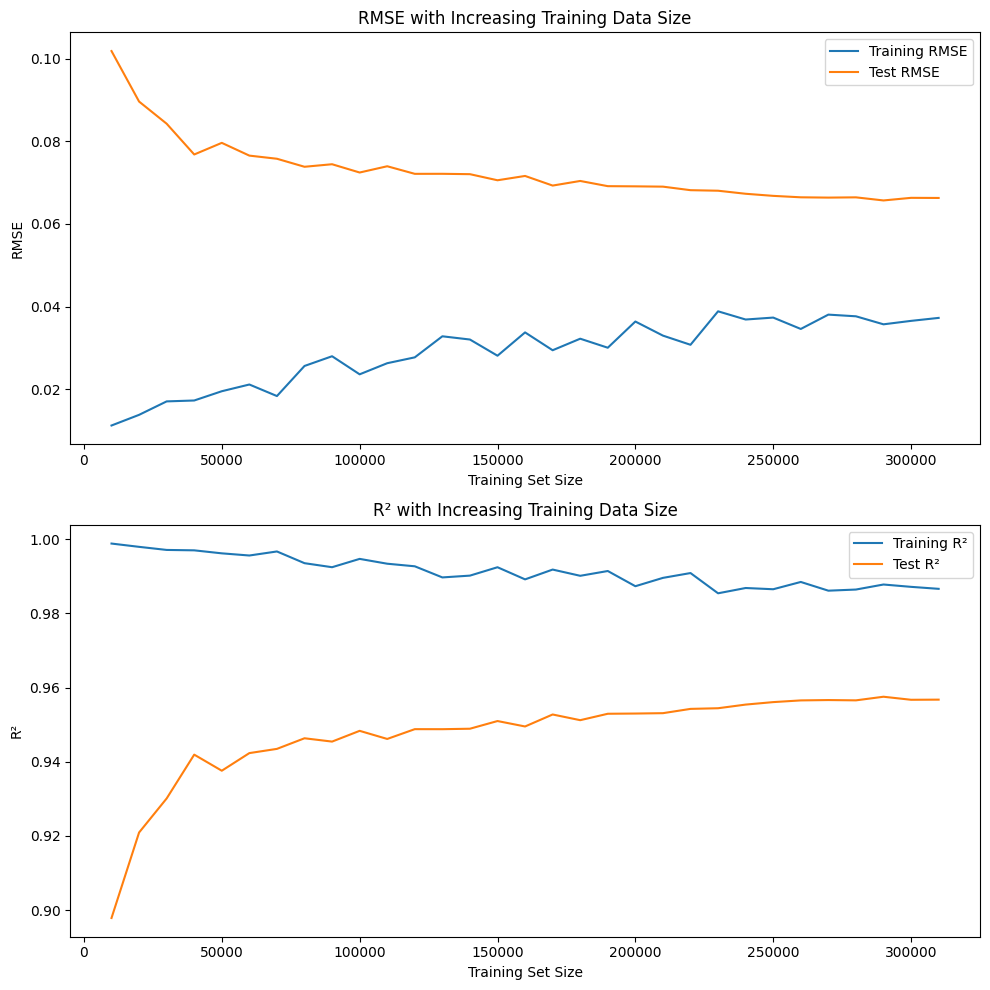

In [192]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define a function to train the model on subsets of the data
def train_with_increasing_data(X_train, y_train, X_test, y_test, params, batch_size=20000, max_data_size=None):
    rmse_train = []
    rmse_test = []
    r2_train = []
    r2_test = []
    
    # Start with an empty DMatrix for training and test data
    for i in range(batch_size, len(X_train) + 1, batch_size):
        # Train on the first i rows of X_train and y_train
        X_train_subset = X_train[:i]
        y_train_subset = y_train[:i]
        
        dtrain = xgb.DMatrix(X_train_subset, label=y_train_subset)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Initialize the evals_result dictionary to collect evaluation results
        evals_result = {}
        
        # Train the model on the current subset
        history = xgb.train(params, dtrain, 
                            num_boost_round=3000, 
                            evals=[(dtrain, 'train'), (dtest, 'eval')],
                            early_stopping_rounds=50,
                            evals_result=evals_result,  # Pass in the evals_result to collect results
                            verbose_eval=False)

        # Collect RMSE for the training and test sets
        train_rmse = evals_result['train']['rmse']
        test_rmse = evals_result['eval']['rmse']
        
        # Compute R² scores for each epoch on training and test set
        train_r2 = r2_score(y_train_subset, history.predict(dtrain, iteration_range=(0, len(train_rmse))))
        test_r2 = r2_score(y_test, history.predict(dtest, iteration_range=(0, len(test_rmse))))
        
        # Save the latest RMSE and R² values
        rmse_train.append(train_rmse[-1])
        rmse_test.append(test_rmse[-1])
        r2_train.append(train_r2)
        r2_test.append(test_r2)
        
        # Stop when the maximum data size is reached (if specified)
        if max_data_size and i >= max_data_size:
            break
    
    return rmse_train, rmse_test, r2_train, r2_test

# Define parameters for the model
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'learning_rate': 0.1, 
    'max_depth': 9, 
    'n_jobs': -1
}

# Train and evaluate the model with increasing data points
batch_size = 10000
rmse_train, rmse_test, r2_train, r2_test = train_with_increasing_data(
    X_train, y_train, X_test, y_test, params, batch_size=batch_size, max_data_size=len(X_train))

# Step 5: Plot RMSE and R² for both training and test sets as the data size increases
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot RMSE
axs[0].plot(range(batch_size, len(X_train) + 1, batch_size), rmse_train, label='Training RMSE')
axs[0].plot(range(batch_size, len(X_train) + 1, batch_size), rmse_test, label='Test RMSE')
axs[0].set_title('RMSE with Increasing Training Data Size')
axs[0].set_xlabel('Training Set Size')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# Plot R²
axs[1].plot(range(batch_size, len(X_train) + 1, batch_size), r2_train, label='Training R²')
axs[1].plot(range(batch_size, len(X_train) + 1, batch_size), r2_test, label='Test R²')
axs[1].set_title('R² with Increasing Training Data Size')
axs[1].set_xlabel('Training Set Size')
axs[1].set_ylabel('R²')
axs[1].legend()

plt.tight_layout()
plt.show()


In [225]:
sizes = [10, 100, 1000, 10000, 100000]
for size in sizes:
    Xt = X_train.sample(frac=1.0)[:size]
    start_time = time.time()
    best_model.predict(Xt)
    end_time = time.time()
    time_diff = end_time - start_time
    print(f"Eval time for {len(Xt)} rows: {time_diff:.4f} seconds")



Eval time for 10 rows: 0.0083 seconds
Eval time for 100 rows: 0.0073 seconds
Eval time for 1000 rows: 0.0094 seconds
Eval time for 10000 rows: 0.0301 seconds
Eval time for 100000 rows: 0.2551 seconds


In [207]:
Xt.columns

Index(['score_diff', 'total_unseen_tiles', 'leave_A', 'leave_B', 'leave_C',
       'leave_D', 'leave_E', 'leave_F', 'leave_G', 'leave_H', 'leave_I',
       'leave_J', 'leave_K', 'leave_L', 'leave_M', 'leave_N', 'leave_O',
       'leave_P', 'leave_Q', 'leave_R', 'leave_S', 'leave_T', 'leave_U',
       'leave_V', 'leave_W', 'leave_X', 'leave_Y', 'leave_Z', 'leave_?',
       'unseen_A', 'unseen_B', 'unseen_C', 'unseen_D', 'unseen_E', 'unseen_F',
       'unseen_G', 'unseen_H', 'unseen_I', 'unseen_J', 'unseen_K', 'unseen_L',
       'unseen_M', 'unseen_N', 'unseen_O', 'unseen_P', 'unseen_Q', 'unseen_R',
       'unseen_S', 'unseen_T', 'unseen_U', 'unseen_V', 'unseen_W', 'unseen_X',
       'unseen_Y', 'unseen_Z', 'unseen_?'],
      dtype='object')

In [208]:
print(set(best_model.get_booster().feature_names) - set(Xt.columns))
print(set(Xt.columns) - set(best_model.get_booster().feature_names))

set()
{'unseen_C', 'unseen_Q', 'unseen_N', 'unseen_D', 'unseen_R', 'unseen_G', 'unseen_B', 'unseen_I', 'unseen_J', 'unseen_A', 'unseen_W', 'unseen_X', 'unseen_T', 'unseen_Z', 'unseen_S', 'unseen_U', 'unseen_L', 'unseen_E', 'unseen_K', 'unseen_Y', 'unseen_O', 'unseen_P', 'unseen_?', 'unseen_V', 'unseen_M', 'unseen_F', 'unseen_H'}


In [210]:
set(Xt.columns)

{'leave_?',
 'leave_A',
 'leave_B',
 'leave_C',
 'leave_D',
 'leave_E',
 'leave_F',
 'leave_G',
 'leave_H',
 'leave_I',
 'leave_J',
 'leave_K',
 'leave_L',
 'leave_M',
 'leave_N',
 'leave_O',
 'leave_P',
 'leave_Q',
 'leave_R',
 'leave_S',
 'leave_T',
 'leave_U',
 'leave_V',
 'leave_W',
 'leave_X',
 'leave_Y',
 'leave_Z',
 'score_diff',
 'total_unseen_tiles',
 'unseen_?',
 'unseen_A',
 'unseen_B',
 'unseen_C',
 'unseen_D',
 'unseen_E',
 'unseen_F',
 'unseen_G',
 'unseen_H',
 'unseen_I',
 'unseen_J',
 'unseen_K',
 'unseen_L',
 'unseen_M',
 'unseen_N',
 'unseen_O',
 'unseen_P',
 'unseen_Q',
 'unseen_R',
 'unseen_S',
 'unseen_T',
 'unseen_U',
 'unseen_V',
 'unseen_W',
 'unseen_X',
 'unseen_Y',
 'unseen_Z'}

In [211]:
best_model.get_booster().feature_names

['score_diff',
 'total_unseen_tiles',
 'leave_A',
 'leave_B',
 'leave_C',
 'leave_D',
 'leave_E',
 'leave_F',
 'leave_G',
 'leave_H',
 'leave_I',
 'leave_J',
 'leave_K',
 'leave_L',
 'leave_M',
 'leave_N',
 'leave_O',
 'leave_P',
 'leave_Q',
 'leave_R',
 'leave_S',
 'leave_T',
 'leave_U',
 'leave_V',
 'leave_W',
 'leave_X',
 'leave_Y',
 'leave_Z',
 'leave_?']